## Load Libraries

In [61]:
# Core libraries
import os
import shutil
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from tqdm import tqdm

# Audio processing
import librosa
import soundfile as sf

# Machine learning tools
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix

# PyTorch
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

# For reproducibility
import random
random.seed(42)
np.random.seed(42)
torch.manual_seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(42)

## Data Augmentation

In [62]:
def augment_data(audio_file_path, output_dir, chord_label, num_augmentations=5):
    """Generate augmented versions of an audio file"""
    y, sr = librosa.load(audio_file_path, sr=None)
    
    # Create output directory if it doesn't exist
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)
    
    # Original file
    filename = os.path.basename(audio_file_path)
    chord_dir = os.path.join(output_dir, chord_label)
    if not os.path.exists(chord_dir):
        os.makedirs(chord_dir)
    
    # Copy original file
    shutil.copy(audio_file_path, os.path.join(chord_dir, filename))
    
    augmentations = []
    
    # 1. Pitch shift variations (subtle shifts that preserve chord identity)
    for i, cents in enumerate([15, -15, 30, -30]):
        y_shifted = librosa.effects.pitch_shift(y, sr=sr, n_steps=cents/100)
        output_path = os.path.join(chord_dir, f"{os.path.splitext(filename)[0]}_pitch{i}.wav")
        sf.write(output_path, y_shifted, sr)
        augmentations.append(output_path)
        
    # 2. Time stretching (subtle to preserve chord character)
    for i, rate in enumerate([0.95, 1.05]):
        y_stretched = librosa.effects.time_stretch(y, rate=rate)
        output_path = os.path.join(chord_dir, f"{os.path.splitext(filename)[0]}_stretch{i}.wav")
        sf.write(output_path, y_stretched, sr)
        augmentations.append(output_path)
    
    # 3. Add small amount of noise
    y_noise = y + 0.005 * np.random.randn(len(y))
    output_path = os.path.join(chord_dir, f"{os.path.splitext(filename)[0]}_noise.wav")
    sf.write(output_path, y_noise, sr)
    augmentations.append(output_path)
    
    return augmentations

## Feature Extraction Preparation

In [63]:
def extract_features(file_path):
    # Load audio with original sample rate
    y, sr = librosa.load(file_path, sr=None, mono=True)
    
    # Compute chromagram - most important for chord detection
    chroma = librosa.feature.chroma_cqt(y=y, sr=sr, bins_per_octave=36, n_chroma=12, hop_length=512)
    
    # Add harmonic-percussive separation to focus on harmonic content
    y_harmonic, _ = librosa.effects.hpss(y)
    chroma_harmonic = librosa.feature.chroma_cqt(y=y_harmonic, sr=sr, bins_per_octave=36, n_chroma=12)
    
    # Compute tonnetz features (harmonic relationships)
    tonnetz = librosa.feature.tonnetz(y=y_harmonic, sr=sr)
    
    # Extract onset envelope for attack characteristics
    onset_env = librosa.onset.onset_strength(y=y, sr=sr)
    onset_env = onset_env.reshape(1, -1)
    
    # Stack all features
    features = np.vstack([
        chroma,             # Basic pitch class content (12)
        chroma_harmonic,    # Cleaner pitch content (12)
        tonnetz,            # Harmonic relationships (6)
        onset_env           # Attack characteristics (1)
    ])
    
    return features

## Dataset Loader (PyTorch Dataset Class)

In [64]:
class GuitarChordDataset(Dataset):
    def __init__(self, features, labels):
        self.features = features
        self.labels = labels
        
    def __len__(self):
        return len(self.features)
    
    def __getitem__(self, idx):
        feature = self.features[idx]
        label = self.labels[idx]
        return torch.tensor(feature, dtype=torch.float32), torch.tensor(label, dtype=torch.long)

## Data Loading and Preprocessing

In [65]:
# Set your data directory
data_dir = "./Chords_WAV"
augmented_dir = "./Augmented_Chords_WAV"

# Analyze class distribution
class_counts = {}
for folder in os.listdir(data_dir):
    folder_path = os.path.join(data_dir, folder)
    if os.path.isdir(folder_path):
        chord_files = [f for f in os.listdir(folder_path) if f.endswith('.wav')]
        if chord_files:
            chord_name = chord_files[0].split('_')[0]
            class_counts[chord_name] = len(chord_files)

print("Original class distribution:")
for chord, count in sorted(class_counts.items()):
    print(f"{chord}: {count} files")

# Apply data augmentation
if not os.path.exists(augmented_dir):
    print("\nAugmenting data...")
    for folder in tqdm(os.listdir(data_dir)):
        folder_path = os.path.join(data_dir, folder)
        if os.path.isdir(folder_path):
            for file in os.listdir(folder_path):
                if file.endswith(".wav"):
                    file_path = os.path.join(folder_path, file)
                    chord_label = file.split('_')[0]
                    augment_data(file_path, augmented_dir, chord_label)
    print("Data augmentation complete!")

# Load all the files (original + augmented)
features = []
labels = []
file_paths = []

# Process the augmented dataset
print("\nProcessing augmented dataset...")
for folder in tqdm(os.listdir(augmented_dir)):
    folder_path = os.path.join(augmented_dir, folder)
    if os.path.isdir(folder_path):
        for file in os.listdir(folder_path):
            if file.endswith(".wav"):
                file_path = os.path.join(folder_path, file)
                try:
                    feature_matrix = extract_features(file_path)
                    chord_label = folder  # The folder name is the chord label
                    features.append(feature_matrix)
                    labels.append(chord_label)
                    file_paths.append(file_path)
                except Exception as e:
                    print(f"Failed to process {file_path}: {e}")

# Check the new distribution
print("\nAugmented class distribution:")
augmented_counts = {}
for label in labels:
    augmented_counts[label] = augmented_counts.get(label, 0) + 1
for chord, count in sorted(augmented_counts.items()):
    print(f"{chord}: {count} files")

# Encode string labels
label_encoder = LabelEncoder()
numeric_labels = label_encoder.fit_transform(labels)
print(f"\nNumber of classes: {len(label_encoder.classes_)}")
print(f"Classes: {label_encoder.classes_}")

# Padding function
def pad_or_truncate(feature_matrix, max_length):
    if feature_matrix.shape[1] > max_length:
        return feature_matrix[:, :max_length]
    else:
        padded = np.zeros((feature_matrix.shape[0], max_length))
        padded[:, :feature_matrix.shape[1]] = feature_matrix
        return padded

# Find max dimensions to standardize
max_time_steps = max(f.shape[1] for f in features)
feature_dim = features[0].shape[0]

print(f"\nMax time steps: {max_time_steps}")
print(f"Feature dimensions: {feature_dim}")

# Standardize features
standardized_features = [pad_or_truncate(f, max_time_steps) for f in features]
X = np.array(standardized_features)

# Train-test split - with increased test size and stratification
X_train, X_test, y_train, y_test = train_test_split(
    X, numeric_labels, test_size=0.3, random_state=42, stratify=numeric_labels
)

# Create datasets and dataloaders
train_dataset = GuitarChordDataset(X_train, y_train)
test_dataset = GuitarChordDataset(X_test, y_test)

batch_size = 16
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

Original class distribution:
A#m: 6 files
Am: 6 files
Bm: 6 files
C#m: 6 files
Cm: 6 files
D#m: 6 files
Dm: 6 files
Em: 6 files
F#m: 6 files
Fm: 6 files
G#m: 6 files
Gm: 6 files

Processing augmented dataset...


100%|██████████| 24/24 [05:28<00:00, 13.70s/it]


Augmented class distribution:
A: 24 files
A#: 24 files
A#m: 24 files
Am: 24 files
B: 24 files
Bm: 24 files
C: 24 files
C#: 24 files
C#m: 24 files
Cm: 24 files
D: 24 files
D#: 24 files
D#m: 24 files
Dm: 24 files
E: 24 files
Em: 24 files
F: 24 files
F#: 24 files
F#m: 24 files
Fm: 24 files
G: 24 files
G#: 24 files
G#m: 24 files
Gm: 24 files

Number of classes: 24
Classes: ['A' 'A#' 'A#m' 'Am' 'B' 'Bm' 'C' 'C#' 'C#m' 'Cm' 'D' 'D#' 'D#m' 'Dm' 'E'
 'Em' 'F' 'F#' 'F#m' 'Fm' 'G' 'G#' 'G#m' 'Gm']

Max time steps: 619
Feature dimensions: 31


## Hybrid CNN-RNN Model with Regularization

In [66]:
class SimpleChordCNN(nn.Module):
    def __init__(self, input_channels, num_classes):
        super(SimpleChordCNN, self).__init__()
        
        self.conv = nn.Sequential(
            # First layer - fewer filters
            nn.Conv2d(1, 8, kernel_size=3, padding=1),
            nn.BatchNorm2d(8),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Dropout2d(0.3),  # More dropout
            
            # Second layer - fewer filters
            nn.Conv2d(8, 16, kernel_size=3, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Dropout2d(0.3)  # More dropout
        )
        
        # Adaptive pooling to handle variable input sizes
        self.adaptive_pool = nn.AdaptiveAvgPool2d((4, 4))
        
        # Fully connected with regularization
        self.fc = nn.Sequential(
            nn.Flatten(),
            nn.Linear(16 * 4 * 4, 64),  # Smaller hidden layer
            nn.ReLU(),
            nn.Dropout(0.5),  # Heavy dropout
            nn.Linear(64, num_classes)
        )
        
    def forward(self, x):
        x = x.unsqueeze(1)  # Add channel dimension
        x = self.conv(x)
        x = self.adaptive_pool(x)
        x = self.fc(x)
        return x

## Training Function

In [67]:
def train_model_with_weighting(model, train_loader, test_loader, num_epochs=40):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)
    
    # Compute class weights based on class frequencies
    class_counts = np.bincount(y_train)
    class_weights = 1.0 / class_counts
    class_weights = torch.FloatTensor(class_weights).to(device)
    
    # Weighted loss function
    criterion = nn.CrossEntropyLoss(weight=class_weights)
    
    # Optimizer with weight decay
    optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=0.0001)
    
    # Learning rate scheduler
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=3, factor=0.5)
    
    # For early stopping
    best_accuracy = 0
    patience = 7
    counter = 0
    
    # Training history
    history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}
    
    for epoch in range(num_epochs):
        # Training
        model.train()
        train_loss = 0
        correct = 0
        total = 0
        
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()
        
        train_loss = train_loss / len(train_loader)
        train_acc = 100.0 * correct / total
        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)
        
        # Validation
        model.eval()
        val_loss = 0
        correct = 0
        total = 0
        
        with torch.no_grad():
            for inputs, labels in test_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                
                val_loss += loss.item()
                _, predicted = outputs.max(1)
                total += labels.size(0)
                correct += predicted.eq(labels).sum().item()
        
        val_loss = val_loss / len(test_loader)
        val_acc = 100.0 * correct / total
        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc)
        
        # Update learning rate
        scheduler.step(val_loss)
        
        # Print statistics
        print(f'Epoch: {epoch+1}/{num_epochs} | '
              f'Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.2f}% | '
              f'Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.2f}% | '
              f'LR: {optimizer.param_groups[0]["lr"]:.6f}')
        
        # Early stopping
        if val_acc > best_accuracy:
            best_accuracy = val_acc
            counter = 0
            # Save best model
            torch.save(model.state_dict(), 'best_chord_model.pt')
        else:
            counter += 1
            if counter >= patience:
                print(f'Early stopping at epoch {epoch+1}')
                break
    
    # Load best model
    model.load_state_dict(torch.load('best_chord_model.pt'))
    return model, history

## Model Initialization and Training

In [68]:
# Initialize model
num_classes = len(label_encoder.classes_)
input_channels = X_train.shape[1]  # Number of feature channels

model = SimpleChordCNN(input_channels, num_classes)
print(f"Model structure:\n{model}")

# Train the model
model, history = train_model_with_weighting(
    model, train_loader, test_loader, num_epochs=40
)

Model structure:
SimpleChordCNN(
  (conv): Sequential(
    (0): Conv2d(1, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Dropout2d(p=0.3, inplace=False)
    (5): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): ReLU()
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (9): Dropout2d(p=0.3, inplace=False)
  )
  (adaptive_pool): AdaptiveAvgPool2d(output_size=(4, 4))
  (fc): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=256, out_features=64, bias=True)
    (2): ReLU()
    (3): Dropout(p=0.5, inplace=False)
    (4): Linear(in_features=64, out_features=24, bias=True)
  )
)
Epoch: 1/40 | Train Loss: 3.1917 |

## Model Evaluation

Test Accuracy: 0.9364

Classification Report:
              precision    recall  f1-score   support

           A       1.00      1.00      1.00         7
          A#       1.00      1.00      1.00         7
         A#m       1.00      1.00      1.00         7
          Am       1.00      1.00      1.00         7
           B       1.00      0.86      0.92         7
          Bm       1.00      0.86      0.92         7
           C       0.89      1.00      0.94         8
          C#       0.80      1.00      0.89         8
         C#m       1.00      0.86      0.92         7
          Cm       0.86      0.86      0.86         7
           D       1.00      0.88      0.93         8
          D#       1.00      1.00      1.00         7
         D#m       1.00      1.00      1.00         7
          Dm       0.88      1.00      0.93         7
           E       0.89      1.00      0.94         8
          Em       1.00      0.71      0.83         7
           F       0.78      1.00  

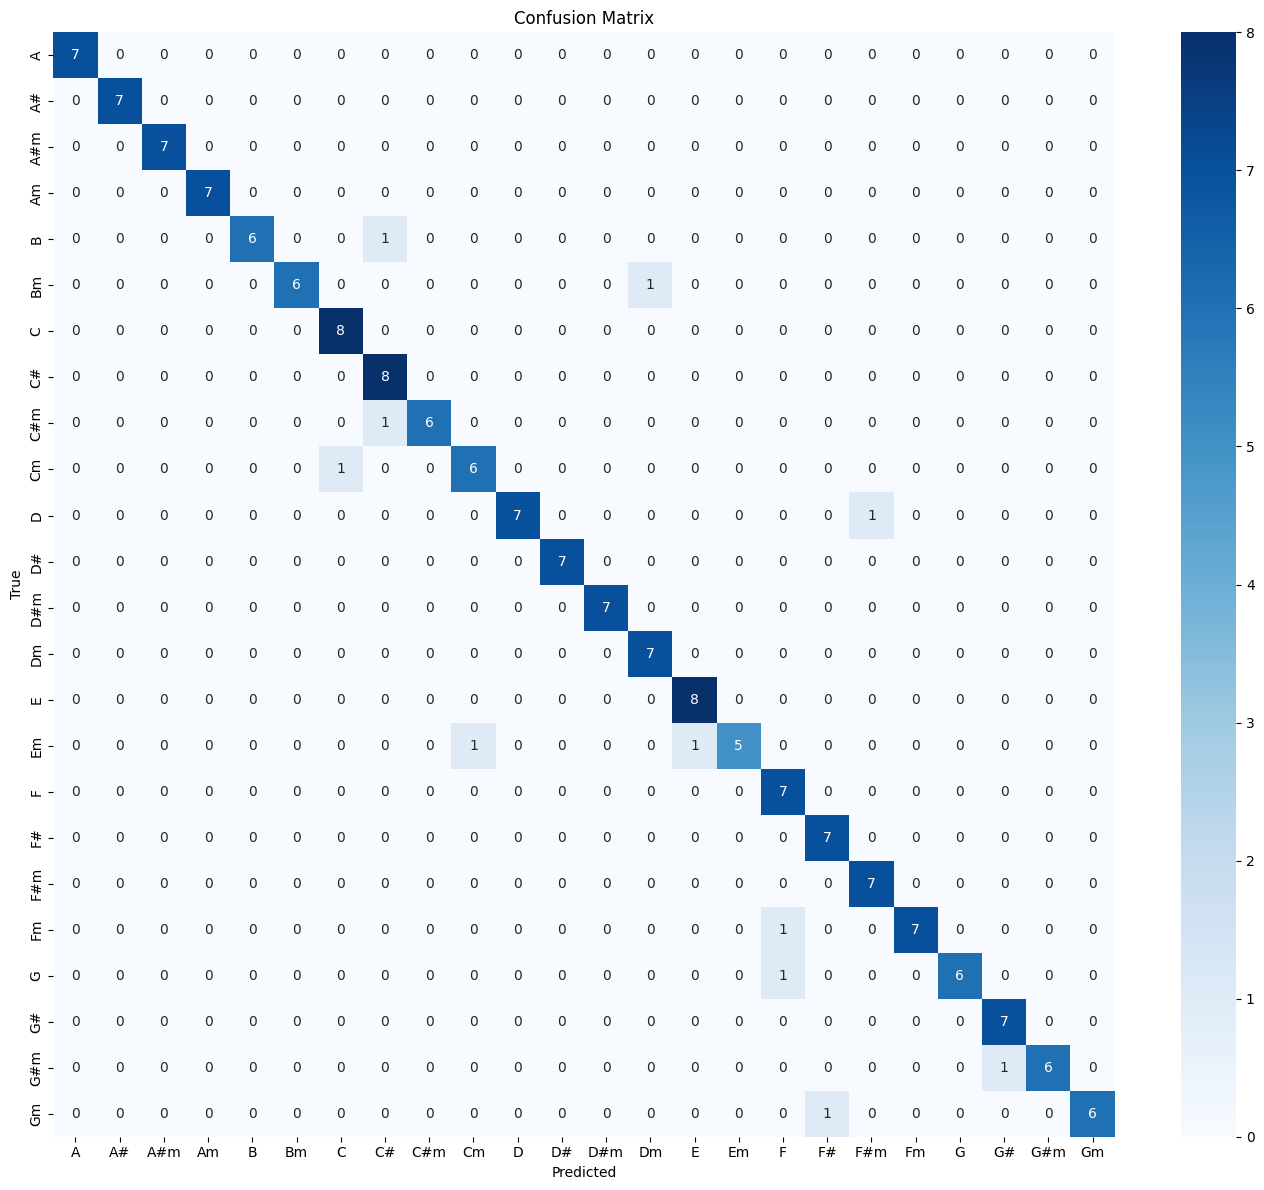

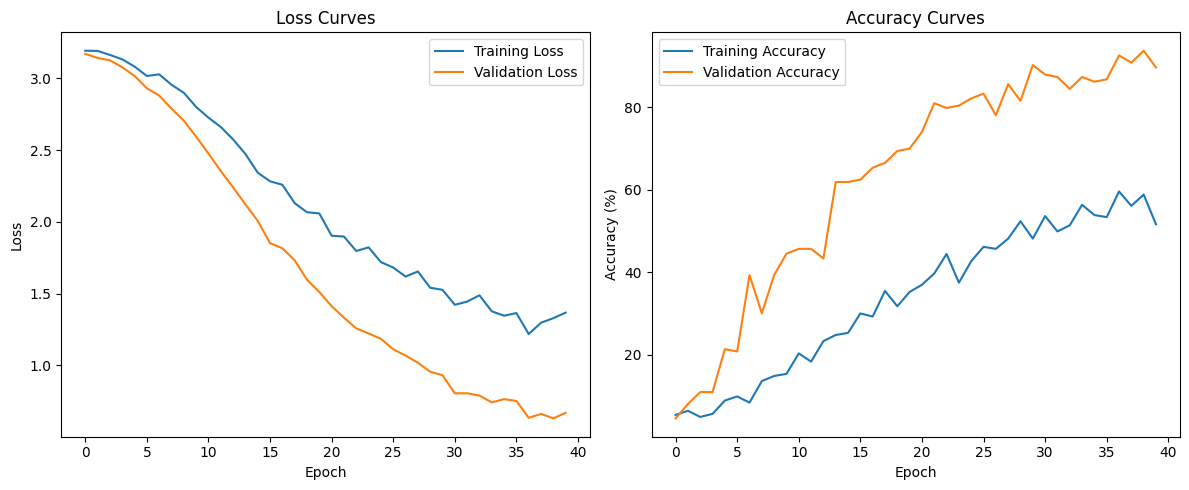

In [69]:
# Evaluate model
model.eval()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
all_preds = []
all_labels = []
all_probs = []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        probs = F.softmax(outputs, dim=1)
        _, predicted = outputs.max(1)
        
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())
        all_probs.extend(probs.cpu().numpy())

# Convert predictions back to chord names
decoded_preds = label_encoder.inverse_transform(all_preds)
decoded_true = label_encoder.inverse_transform(all_labels)

# Calculate accuracy and print report
accuracy = accuracy_score(all_labels, all_preds)
print(f"Test Accuracy: {accuracy:.4f}")

print("\nClassification Report:")
print(classification_report(decoded_true, decoded_preds))

# Print sample predictions
print("\nSample Predictions:")
for i in range(min(10, len(decoded_preds))):
    print(f"True: {decoded_true[i]}, Predicted: {decoded_preds[i]}")

# Plot confusion matrix
plt.figure(figsize=(14, 12))
cm = confusion_matrix(decoded_true, decoded_preds)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=label_encoder.classes_, 
            yticklabels=label_encoder.classes_)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.tight_layout()
plt.savefig('confusion_matrix.png')
plt.show()

# Plot training curves
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history['train_loss'], label='Training Loss')
plt.plot(history['val_loss'], label='Validation Loss')
plt.title('Loss Curves')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history['train_acc'], label='Training Accuracy')
plt.plot(history['val_acc'], label='Validation Accuracy')
plt.title('Accuracy Curves')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()

plt.tight_layout()
plt.savefig('training_curves.png')
plt.show()

## Best Model

In [70]:
# Save the final model with accuracy check for overwriting
def save_model_if_better(model, label_encoder, input_channels, num_classes, max_time_steps, 
                         current_accuracy, model_path='guitar_chord_recognition_model.pth'):
    """Save model if it has better accuracy than previous saved model, or if no model exists"""
    
    save_model = True
    
    # Check if model file already exists
    if os.path.exists(model_path):
        try:
            # Load existing model to check accuracy
            checkpoint = torch.load(model_path)
            previous_accuracy = checkpoint.get('accuracy', 0)
            
            # Only save if current model is better
            if current_accuracy > previous_accuracy:
                print(f"New model accuracy ({current_accuracy:.4f}) is better than previous ({previous_accuracy:.4f}). Saving model.")
            else:
                print(f"Current accuracy ({current_accuracy:.4f}) is not better than existing model ({previous_accuracy:.4f}). Model not saved.")
                save_model = False
                
        except Exception as e:
            print(f"Error loading previous model: {e}. Will save new model.")
            save_model = True
    
    # Save model if it's better or if no previous model exists
    if save_model:
        torch.save({
            'model_state_dict': model.state_dict(),
            'label_encoder': label_encoder,
            'input_channels': input_channels,
            'num_classes': num_classes,
            'max_time_steps': max_time_steps,
            'accuracy': current_accuracy
        }, model_path)
        print(f"Model saved successfully with accuracy: {current_accuracy:.4f}")

# Call after evaluation
save_model_if_better(
    model, 
    label_encoder, 
    input_channels, 
    num_classes, 
    max_time_steps,
    accuracy,  # This is your 0.9364 accuracy value
    'guitar_chord_recognition_model.pth'
)

# Improved function to recognize chords from new files
def recognize_chord(file_path, model_path='guitar_chord_recognition_model.pth'):
    """Recognize guitar chord from an audio file"""
    
    # Load model
    if not os.path.exists(model_path):
        raise FileNotFoundError(f"Model file {model_path} not found. Please train the model first.")
        
    checkpoint = torch.load(model_path)
    
    # Initialize model
    model = SimpleChordCNN(checkpoint['input_channels'], checkpoint['num_classes'])
    model.load_state_dict(checkpoint['model_state_dict'])
    label_encoder = checkpoint['label_encoder']
    max_time_steps = checkpoint['max_time_steps']
    
    # Extract features
    features = extract_features(file_path)
    
    # Pad to match training dimensions
    padded_features = pad_or_truncate(features, max_time_steps)
    
    # Convert to tensor
    features_tensor = torch.tensor(padded_features, dtype=torch.float32).unsqueeze(0)
    
    # Set device
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)
    features_tensor = features_tensor.to(device)
    
    # Recognize chord
    model.eval()
    with torch.no_grad():
        outputs = model(features_tensor)
        probs = F.softmax(outputs, dim=1)
        
    # Get top 3 predictions
    top_probs, top_indices = torch.topk(probs, 3)
    top_chords = label_encoder.inverse_transform(top_indices[0].cpu().numpy())
    top_confidences = top_probs[0].cpu().numpy()
    
    results = {
        'recognized_chord': top_chords[0],
        'confidence': float(top_confidences[0]),
        'alternatives': [
            {'chord': chord, 'confidence': float(conf)} 
            for chord, conf in zip(top_chords[1:], top_confidences[1:])
        ]
    }
    
    return results

# Example usage
"""
# Test on a new file
result = recognize_chord('path/to/your/new/chord.wav')
print(f"Recognized chord: {result['recognized_chord']} with {result['confidence']*100:.2f}% confidence")
print("Alternative recognitions:")
for alt in result['alternatives']:
    print(f"- {alt['chord']}: {alt['confidence']*100:.2f}%")
"""

Current accuracy (0.9364) is not better than existing model (0.9364). Model not saved.


'\n# Test on a new file\nresult = recognize_chord(\'path/to/your/new/chord.wav\')\nprint(f"Recognized chord: {result[\'recognized_chord\']} with {result[\'confidence\']*100:.2f}% confidence")\nprint("Alternative recognitions:")\nfor alt in result[\'alternatives\']:\n    print(f"- {alt[\'chord\']}: {alt[\'confidence\']*100:.2f}%")\n'